# Exploratory Data Analysis

## 1. Importations

In [21]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import h5py
import joblib

## 2. Loading and Preparing Data

In [2]:
# Loading the Malaria dataset
dataset, info = tfds.load('malaria', split=['train'], with_info=True, as_supervised=True)

# Unpacking the dataset
df_malaria = dataset[0]

print(info)

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir='C:\\Users\\tiger\\tensorflow_datasets\\malaria\\1.0.0',
    file_format=tfrecord,
    download_size=Unknown size,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thi

In [3]:
# Preprocessing function
def preprocess(image, label):
    # Resizing images to a fixed size
    image = tf.image.resize(image, (128, 128))
    # Normalizing pixel values
    image = image / 255
    return image, label

In [4]:
# Applying preprocessing
batch_size = 256
prefetch_buffer_size = tf.data.AUTOTUNE

df_malaria = (
    df_malaria.map(preprocess) # Applying the preprocess function to each element in the dataset
              .shuffle(buffer_size=1000) # Randomizing the order of samples in the dataset to reduce bias during training
              #.batch(batch_size) # Groups the dataset into batches of 256 elements for efficient training
              .prefetch(prefetch_buffer_size) # Overlaping data preparation and model execution to maximize training performance
)

In [5]:
# Iterating through the dataset
for images, labels in df_malaria.take(1): # Taking 1 batch
    print(f"Image batch shape: {images.shape}")
    print(f"Label batch shape: {labels.shape}")

Image batch shape: (128, 128, 3)
Label batch shape: ()


### Images Visualization

In [8]:
def plot_images(df, num_images=10):
    '''
    Displays a number of images (default: 10) contained in a dataset

    Parameters:
        - df: the dataset containing images
        - num_images: the number of images you want to display (default: 10)
    '''
    plt.figure(figsize=(15, 8))
    for i, (image, label) in enumerate(df.take(num_images)):
        plt.subplot(2, 5, i+1)
        plt.imshow(image.numpy())
        plt.title("Parasitised" if label.numpy() == 0 else "Uninfected")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

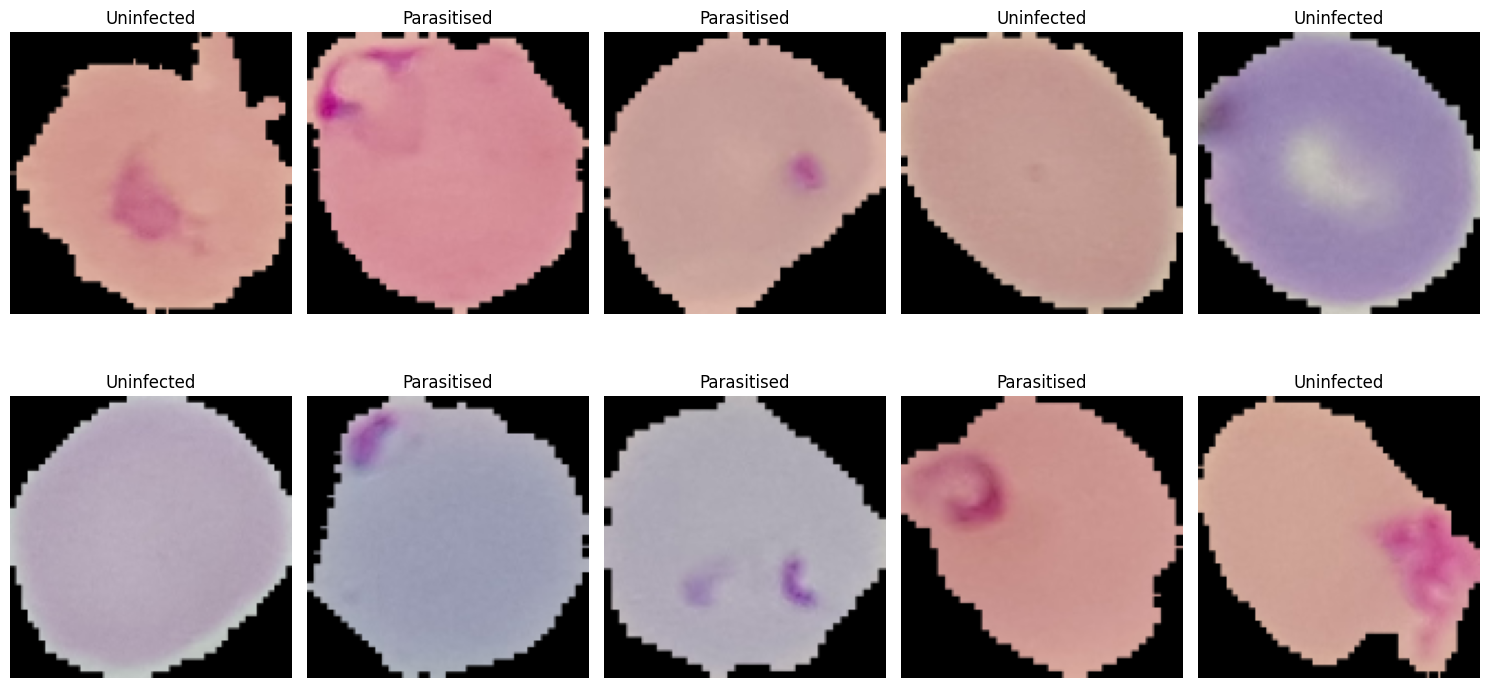

In [9]:
# unbatched_df = df_malaria.unbatch()

plot_images(df_malaria)

### Splitting Data

In [13]:
# Create an HDF5 file to store the data
with h5py.File('dataset.h5', 'w') as hf:
    # Allocate space for the dataset
    images_dataset = hf.create_dataset('images', (27558, 128, 128, 3), dtype='float32')
    labels_dataset = hf.create_dataset('labels', (27558,), dtype='int')

    i = 0
    for images, labels in df_malaria.batch(32):
        batch_size = images.shape[0]
        images_dataset[i:i + batch_size] = images.numpy()
        labels_dataset[i:i + batch_size] = labels.numpy()
        i += batch_size

In [10]:
# Loading the HDF5 file
with h5py.File('dataset.h5', 'r') as hf:
    images = hf['images'][:]
    labels = hf['labels'][:]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

## 3. Model Training

In [12]:
# Sequential model
model = tf.keras.Sequential([
    tf.keras.Input(shape=(128, 128, 3)),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,392,833 (28.20 MB)

 Trainable params: 7,392,641 (28.20 MB)

 Non-trainable params: 192 (768.00 B)

In [14]:
# Compilation
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

In [15]:
# Preparing early stopping to reduce overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [16]:
# Model training
history = model.fit(
    X_train,
    y_train,
    epochs=15,
    validation_split=0.1,
    callbacks=[early_stopping]
)

Epoch 1/15
621/621 ━━━━━━━━━━━━━━━━━━━━ 466s 744ms/step - accuracy: 0.6169 - loss: 1.3201 - precision: 0.6450 - recall: 0.5130 - val_accuracy: 0.7288 - val_loss: 0.6995 - val_precision: 0.6560 - val_recall: 0.9822
Epoch 2/15
621/621 ━━━━━━━━━━━━━━━━━━━━ 414s 667ms/step - accuracy: 0.8401 - loss: 0.3836 - precision: 0.8223 - recall: 0.8616 - val_accuracy: 0.4916 - val_loss: 1.9142 - val_precision: 1.0000 - val_recall: 8.9127e-04
Epoch 3/15
621/621 ━━━━━━━━━━━━━━━━━━━━ 409s 659ms/step - accuracy: 0.9260 - loss: 0.2032 - precision: 0.9064 - recall: 0.9458 - val_accuracy: 0.9274 - val_loss: 0.2405 - val_precision: 0.8867 - val_recall: 0.9831
Epoch 4/15
621/621 ━━━━━━━━━━━━━━━━━━━━ 408s 656ms/step - accuracy: 0.9338 - loss: 0.1943 - precision: 0.9237 - recall: 0.9472 - val_accuracy: 0.9252 - val_loss: 0.2181 - val_precision: 0.9553 - val_recall: 0.8948
Epoch 5/15
621/621 ━━━━━━━━━━━━━━━━━━━━ 427s 687ms/step - accuracy: 0.9472 - loss: 0.1514 - precision: 0.9375 - recall: 0.9582 - val_accurac

## 4. Model Evaluation

### Results Interpretation

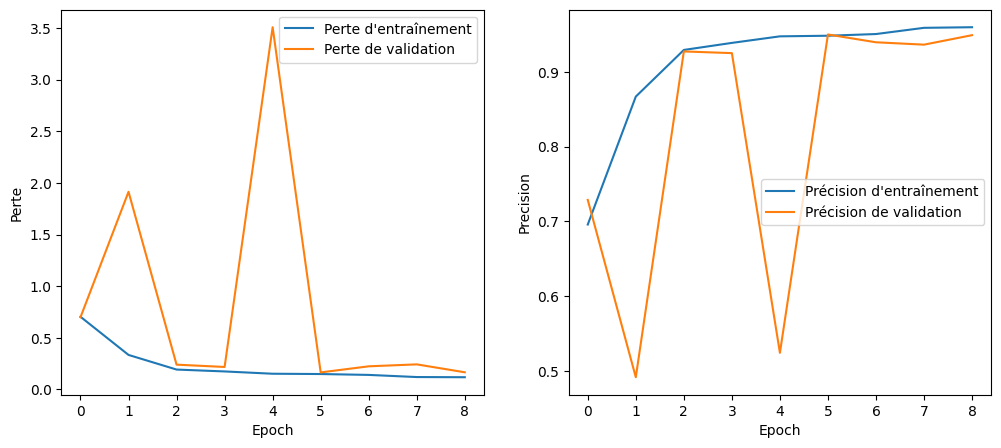

In [17]:
# Loss Display
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Perte d\'entraînement')
plt.plot(history.history['val_loss'], label='Perte de validation')
plt.xlabel('Epoch')
plt.ylabel('Perte')
plt.legend()

# Precision Display
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Précision d\'entraînement')
plt.plot(history.history['val_accuracy'], label='Précision de validation')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.show()

### Evaluation

In [18]:
# Loss and Precision evaluation
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(X_test, y_test)
print(f"Perte sur l'ensemble de test : {test_loss:.4f}")
print(f"Précision sur l'ensemble de test : {test_accuracy * 100:.2f}%")

173/173 ━━━━━━━━━━━━━━━━━━━━ 21s 108ms/step - accuracy: 0.9389 - loss: 0.1925 - precision: 0.9202 - recall: 0.9605
Perte sur l'ensemble de test : 0.1850
Précision sur l'ensemble de test : 94.03%


In [19]:
# Precision on the test set
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int) # Threshold at 0.5

173/173 ━━━━━━━━━━━━━━━━━━━━ 20s 115ms/step


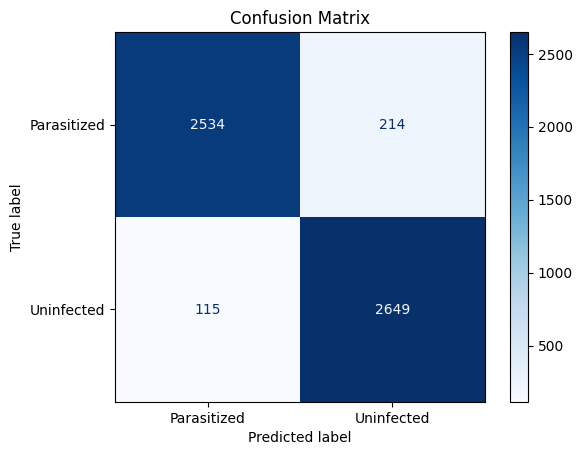

Rapport de classification
              precision    recall  f1-score   support

           0       0.96      0.92      0.94      2748
           1       0.93      0.96      0.94      2764

    accuracy                           0.94      5512
   macro avg       0.94      0.94      0.94      5512
weighted avg       0.94      0.94      0.94      5512



In [20]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

conf_matrix = confusion_matrix(y_test, y_pred)
disb = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Parasitized', 'Uninfected'])
disb.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


class_report = classification_report(y_test, y_pred)
print("Rapport de classification")
print(class_report)

## 5. Saving Model

In [23]:
joblib.dump(model, '../saved_models/malaria_model.joblib')

['../saved_models/malaria_model.joblib']